In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# save the model
import os
os.environ["BENTOML_HOME"] = "./bentoml_store"
import bentoml
from sklearn.preprocessing import StandardScaler


### Préparation des features pour la modélisation

A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation.
* Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
*  Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne.

In [50]:
building_consumption = pd.read_csv("MLData.csv")

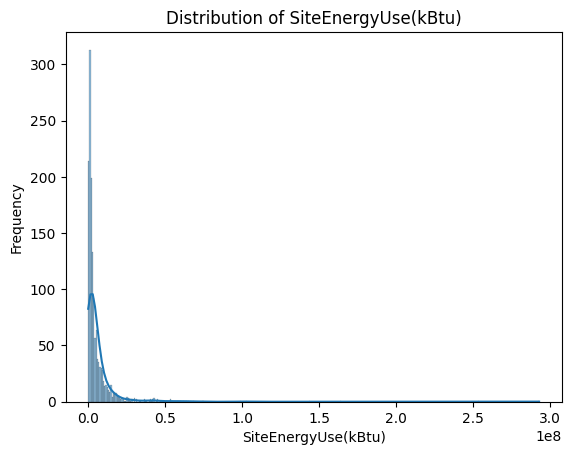

Number of outliers detected: 19


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot target distribution (e.g., for 'SiteEnergyUse(kBtu)')
sns.histplot(building_consumption['SiteEnergyUse(kBtu)'], kde=True)
plt.title('Distribution of SiteEnergyUse(kBtu)')
plt.xlabel('SiteEnergyUse(kBtu)')
plt.ylabel('Frequency')
plt.show()

# Check for outliers (e.g., using Z-score or IQR methods)
from scipy import stats

z_scores = stats.zscore(building_consumption['SiteEnergyUse(kBtu)'])
outliers = building_consumption[abs(z_scores) > 3]
print(f"Number of outliers detected: {len(outliers)}")


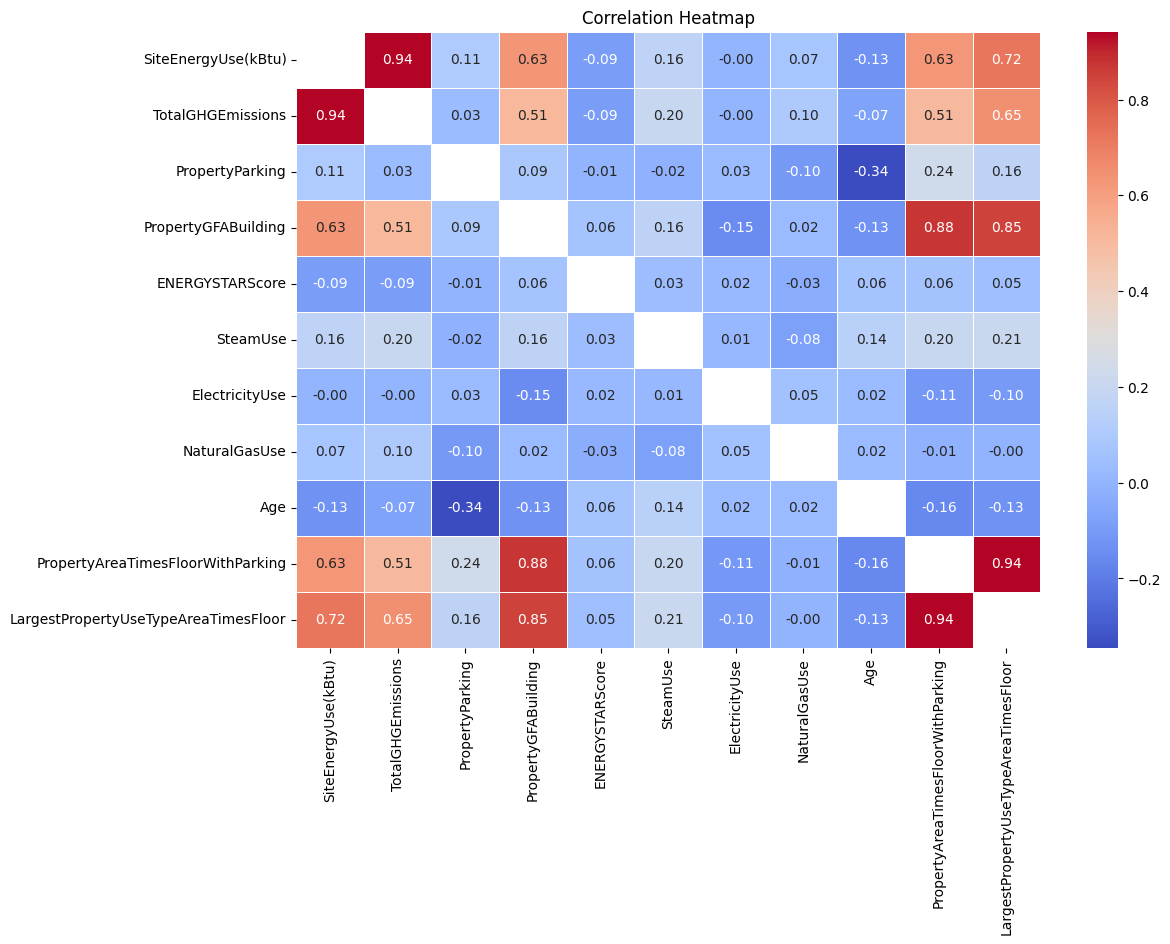

['SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'PropertyAreaTimesFloorWithParking', 'LargestPropertyUseTypeAreaTimesFloor'] sont des colonnes fortement corréllées


In [52]:
# Calculate correlation matrix for numerical features
correlation_matrix = building_consumption.iloc[:, : 11].corr()
np.fill_diagonal(correlation_matrix.values, None) #correlation avec soi même supprimée

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Drop highly correlated features (e.g., threshold of 0.9)
corr_threshold = 0.9
upper = correlation_matrix.where(abs(correlation_matrix) > corr_threshold)
to_drop = [column for column in upper.columns if any(upper[column].dropna())]
print(to_drop, "sont des colonnes fortement corréllées")


In [53]:
try :
    building_consumption.drop("LargestPropertyUseTypeAreaTimesFloor", axis=1, inplace=True)
except:
    building_consumption.drop("LargestPropertyUseTypeGFA", axis=1, inplace=True)
building_consumption

,SiteEnergyUse(kBtu),TotalGHGEmissions,PropertyParking,PropertyGFABuilding,ENERGYSTARScore,SteamUse,ElectricityUse,NaturalGasUse,Age,PropertyAreaTimesFloorWithParking,...,LargestPropertyUseType_Restaurant,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Social/Meeting Hall,LargestPropertyUseType_Strip Mall,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient,LargestPropertyUseType_Wholesale Club/Supercenter,LargestPropertyUseType_Worship Facility
0,8.387933e+06,295.86,1,0.142504,-0.084154,0,1,1,-1.083545,0.932093,...,0,0,0,0,0,0,0,0,0,0
1,6.794584e+06,286.43,0,-0.107519,-0.299046,1,1,1,1.038621,0.303125,...,0,0,0,0,0,0,0,0,0,0
2,1.208662e+07,301.81,1,-0.118833,0.000000,0,1,1,-1.174495,-0.197422,...,0,0,0,0,0,0,0,0,0,0
3,5.758795e+06,176.14,0,0.091969,-1.545417,0,1,1,1.038621,0.661700,...,0,0,0,0,0,0,0,0,0,0
4,6.298132e+06,221.51,0,0.273660,0.000000,1,1,1,1.038621,0.552892,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,8.497457e+05,20.94,0,-0.558466,-0.728829,0,1,1,-0.901645,-0.415376,...,0,0,0,0,0,0,0,0,0,0
1428,9.502762e+05,32.17,0,-0.524378,0.000000,0,1,1,-1.326078,-0.410945,...,0,0,0,0,0,0,0,0,0,0
1429,5.765898e+06,223.54,0,-0.550528,0.000000,0,1,1,-0.416579,-0.414344,...,0,0,0,0,0,0,0,0,0,0
1430,7.194712e+05,22.11,0,-0.541845,0.000000,0,1,1,-0.871329,-0.413216,...,0,0,0,0,0,0,0,0,0,0


In [54]:
building_consumption.columns

Index(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'PropertyParking',
       'PropertyGFABuilding', 'ENERGYSTARScore', 'SteamUse', 'ElectricityUse',
       'NaturalGasUse', 'Age', 'PropertyAreaTimesFloorWithParking',
       'BuildingType_Nonresidential COS', 'BuildingType_Nonresidential WA',
       'CouncilDistrictCode_2', 'CouncilDistrictCode_3',
       'CouncilDistrictCode_4', 'CouncilDistrictCode_5',
       'CouncilDistrictCode_6', 'CouncilDistrictCode_7',
       'LargestPropertyUseType_Automobile Dealership',
       'LargestPropertyUseType_Bank Branch',
       'LargestPropertyUseType_College/University',
       'LargestPropertyUseType_Convention Center',
       'LargestPropertyUseType_Courthouse',
       'LargestPropertyUseType_Data Center',
       'LargestPropertyUseType_Distribution Center',
       'LargestPropertyUseType_Financial Office',
       'LargestPropertyUseType_Fire Station',
       'LargestPropertyUseType_Fitness Center/Health Club/Gym',
       'LargestPropertyUseType_

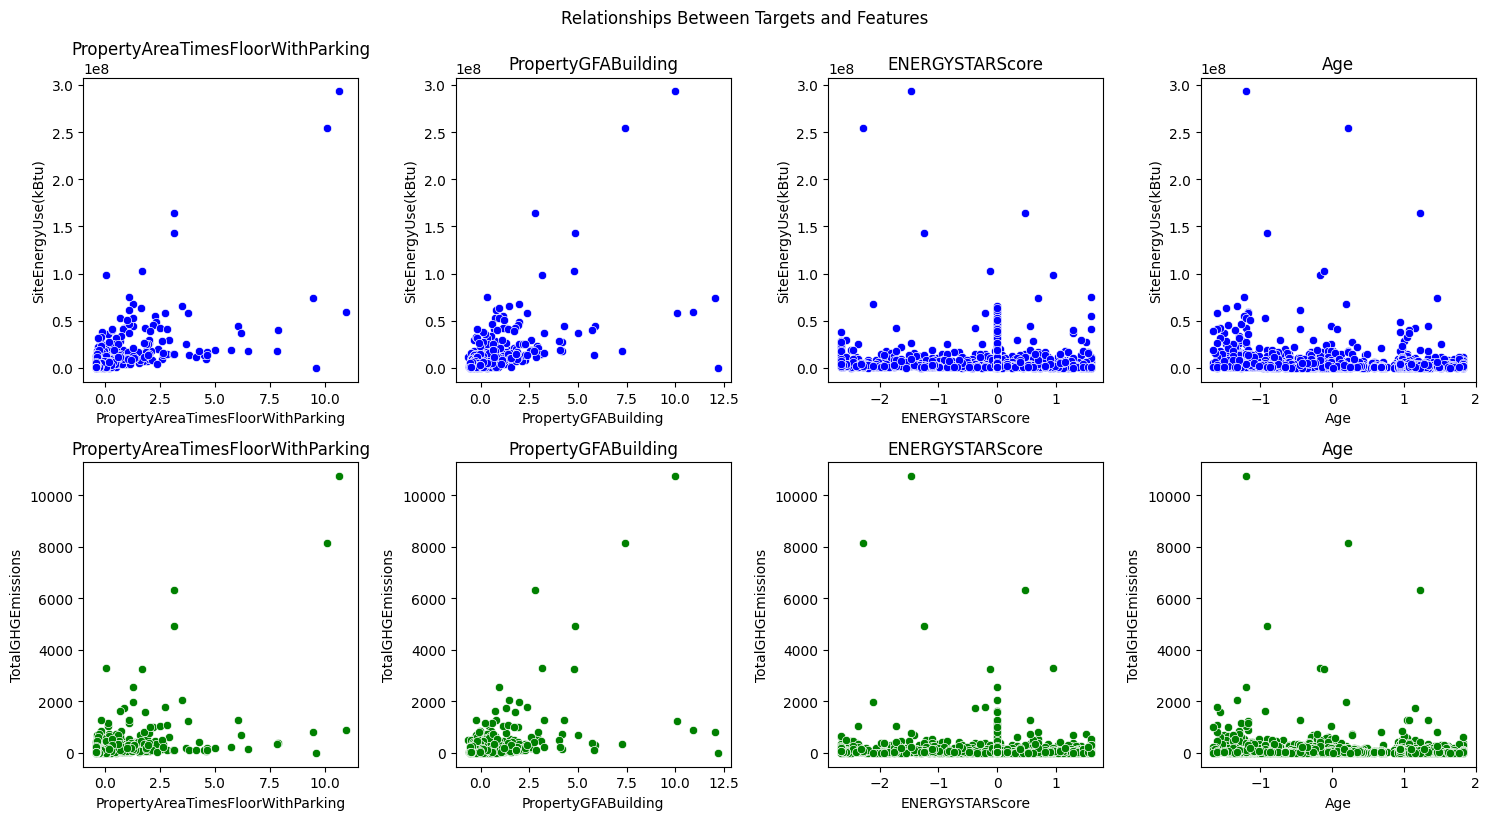

In [55]:
features_to_plot = [
    "PropertyAreaTimesFloorWithParking", "PropertyGFABuilding", 
    "ENERGYSTARScore", "Age"
]


# Create a DataFrame with targets and selected features
df_pairplot = building_consumption[features_to_plot + ["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]]

plt.figure(figsize=(15, 8))

# Plot scatter plots for each feature against the two targets
for i, feature in enumerate(features_to_plot):
    plt.subplot(2, len(features_to_plot), i+1)
    sns.scatterplot(data=df_pairplot, x=feature, y="SiteEnergyUse(kBtu)", color='blue')
    plt.title(f"{feature}")

    plt.subplot(2, len(features_to_plot), i+1+len(features_to_plot))
    sns.scatterplot(data=df_pairplot, x=feature, y="TotalGHGEmissions", color='green')
    plt.title(f"{feature}")

# Adjust layout
plt.tight_layout()
plt.suptitle("Relationships Between Targets and Features", y=1.02)
plt.show()


In [56]:
features = building_consumption.drop(columns=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']) 

target1 = building_consumption['SiteEnergyUse(kBtu)']
target2 = building_consumption['TotalGHGEmissions']

### Comparaison de différents modèles supervisés

A réaliser :
* Pour chaque algorithme que vous allez tester, vous devez :
    * Réaliser au préalable une séparation en jeu d'apprentissage et jeu de test via une validation croisée.
    * Si les features quantitatives que vous souhaitez utiliser ont des ordres de grandeur très différents les uns des autres, et que vous utilisez un algorithme de regression qui est sensible à cette différence, alors il faut réaliser un scaling (normalisation) de la donnée au préalable.
    * Entrainer le modèle sur le jeu de Train
    * Prédire la cible sur la donnée de test (nous appelons cette étape, l'inférence).
    * Calculer les métriques de performance R2, MAE et RMSE sur le jeu de train et de test.
    * Interpréter les résultats pour juger de la fiabilité de l'algorithme.
* Vous pouvez choisir par exemple de tester un modèle linéaire, un modèle à base d'arbres et un modèle de type SVM
* Déterminer le modèle le plus performant parmi ceux testés.

In [57]:
# Train-test split (80% train, 20% test)

X_train1, X_test1, y_train1, y_test1 = train_test_split(features, target1, test_size=0.2, random_state=1337)
X_train2, X_test2, y_train2, y_test2 = train_test_split(features, target2, test_size=0.2, random_state=1337)


## First step, Prediction of SiteEnergyUse(kBtu)

In [58]:

lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train1, y_train1)

# Make predictions
y_train_pred_lr = lr_model.predict(X_train1)
y_test_pred_lr = lr_model.predict(X_test1)

# Calculate metrics for Linear Regression
def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = float(mean_absolute_error(y_true, y_pred))
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    return r2, mae, rmse

train_metrics_lr = evaluate_model(y_train1, y_train_pred_lr)
test_metrics_lr = evaluate_model(y_test1, y_test_pred_lr)

print("Linear Regression (Train) R2, MAE, RMSE:", train_metrics_lr)
print("Linear Regression (Test) R2, MAE, RMSE:", test_metrics_lr)


Linear Regression (Train) R2, MAE, RMSE: (0.7416533218583456, 3305042.2531630164, 8068771.757479208)
Linear Regression (Test) R2, MAE, RMSE: (-4.9846713443641434e+23, 3.62548659885545e+17, 6.140233265168618e+18)


In [59]:
# Initialize Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=1337)

# Train the model
rf_model.fit(X_train1, y_train1)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train1)
y_test_pred_rf = rf_model.predict(X_test1)

# Calculate metrics for Random Forest
train_metrics_rf = evaluate_model(y_train1, y_train_pred_rf)
test_metrics_rf = evaluate_model(y_test1, y_test_pred_rf)

print("Random Forest (Train) R2, MAE, RMSE:", train_metrics_rf)
print("Random Forest (Test) R2, MAE, RMSE:", test_metrics_rf)


Random Forest (Train) R2, MAE, RMSE: (0.9479467121639356, 1142231.028000793, 3621846.771979752)
Random Forest (Test) R2, MAE, RMSE: (0.5565311469618055, 2333524.506011026, 5791594.765063139)


In [60]:
# Initialize Support Vector Regressor model
svr_model = SVR(kernel='linear')

# Train the model
svr_model.fit(X_train1, y_train1)

# Make predictions
y_train_pred_svr = svr_model.predict(X_train1)
y_test_pred_svr = svr_model.predict(X_test1)

# Calculate metrics for SVR
train_metrics_svr = evaluate_model(y_train1, y_train_pred_svr)
test_metrics_svr = evaluate_model(y_test1, y_test_pred_svr)

print("SVR (Train) R2, MAE, RMSE:", train_metrics_svr)
print("SVR (Test) R2, MAE, RMSE:", test_metrics_svr)


SVR (Train) R2, MAE, RMSE: (-0.05920377745025962, 5018068.787414391, 16337881.821376786)
SVR (Test) R2, MAE, RMSE: (-0.10295651987066168, 3894382.9628884695, 9133680.204936426)


In [61]:
# Initialize the Gradient Boosting Regressor model
gb_model = GradientBoostingRegressor(random_state=1337)

# Train the model
gb_model.fit(X_train1, y_train1)

# Make predictions on the training and testing sets
y_train_pred_grad = gb_model.predict(X_train1)
y_test_pred_grad = gb_model.predict(X_test1)


# Calculate metrics for GradientBoosting
train_metrics_grad = evaluate_model(y_train1, y_train_pred_grad)
test_metrics_grad = evaluate_model(y_test1, y_test_pred_grad)

print("GradientBoosting (Train) R2, MAE, RMSE:", train_metrics_grad)
print("GradientBoosting (Test) R2, MAE, RMSE:", test_metrics_grad)



GradientBoosting (Train) R2, MAE, RMSE: (0.956885001433787, 1772620.6715015026, 3296250.26591989)
GradientBoosting (Test) R2, MAE, RMSE: (0.5600041926908441, 2456777.3092203215, 5768871.624374526)


## Second step, Prediction of TotalGHGEmissions

In [62]:
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train2, y_train2)

# Make predictions
y_train_pred_lr = lr_model.predict(X_train2)
y_test_pred_lr = lr_model.predict(X_test2)

train_metrics_lr2 = evaluate_model(y_train2, y_train_pred_lr)
test_metrics_lr2 = evaluate_model(y_test2, y_test_pred_lr)

print("Linear Regression (Train) R2, MAE, RMSE:", train_metrics_lr2)
print("Linear Regression (Test) R2, MAE, RMSE:", test_metrics_lr2)

Linear Regression (Train) R2, MAE, RMSE: (0.6795580593830964, 114.46188751239458, 295.2076060378265)
Linear Regression (Test) R2, MAE, RMSE: (-3.0439650012254953e+24, 15877913317724.283, 268913120699274.97)


In [63]:
# Initialize Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=1337)

# Train the model
rf_model.fit(X_train2, y_train2)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train2)
y_test_pred_rf = rf_model.predict(X_test2)

# Calculate metrics for Random Forest
train_metrics_rf2 = evaluate_model(y_train2, y_train_pred_rf)
test_metrics_rf2 = evaluate_model(y_test2, y_test_pred_rf)

print("Random Forest (Train) R2, MAE, RMSE:", train_metrics_rf2)
print("Random Forest (Test) R2, MAE, RMSE:", test_metrics_rf2)


Random Forest (Train) R2, MAE, RMSE: (0.9389191886548363, 34.69927362445418, 128.88585738276822)
Random Forest (Test) R2, MAE, RMSE: (0.32727555998466795, 59.66158013937283, 126.41853937286498)


In [64]:
# Initialize Support Vector Regressor model
svr_model = SVR(kernel='linear')

# Train the model
svr_model.fit(X_train2, y_train2)

# Make predictions
y_train_pred_svr = svr_model.predict(X_train2)
y_test_pred_svr = svr_model.predict(X_test2)

# Calculate metrics for SVR
train_metrics_svr2 = evaluate_model(y_train2, y_train_pred_svr)
test_metrics_svr2 = evaluate_model(y_test2, y_test_pred_svr)

print("SVR (Train) R2, MAE, RMSE:", train_metrics_svr2)
print("SVR (Test) R2, MAE, RMSE:", test_metrics_svr2)


SVR (Train) R2, MAE, RMSE: (0.13788880070128662, 101.96456481450595, 484.21084223664394)
SVR (Test) R2, MAE, RMSE: (0.23088373859529632, 57.28402759615899, 135.17244275306197)


In [65]:
# Initialize the Gradient Boosting Regressor model
gb_model = GradientBoostingRegressor(random_state=1337)

# Train the model
gb_model.fit(X_train2, y_train2)

# Make predictions on the training and testing sets
y_train_pred_grad = gb_model.predict(X_train2)
y_test_pred_grad = gb_model.predict(X_test2)


# Calculate metrics for SVR
train_metrics_grad2 = evaluate_model(y_train2, y_train_pred_grad)
test_metrics_grad2 = evaluate_model(y_test2, y_test_pred_grad)

print("GradientBoosting (Train) R2, MAE, RMSE:", train_metrics_grad2)
print("GradientBoosting (Test) R2, MAE, RMSE:", test_metrics_grad2)

GradientBoosting (Train) R2, MAE, RMSE: (0.9693984220340982, 51.773781597396216, 91.22729065557576)
GradientBoosting (Test) R2, MAE, RMSE: (0.4081509743021231, 59.8678708417962, 118.57622876937397)


### Testing the main three types of models have shown that Random Forest seems more suited, this has led to test Gradient Boosting which performs even better

We can also see that both targets performs reasonably similarly on all models, I won't be testing both  in parallel for further testing

We will further test XGBoost, LightGBM, AdaBoost

In [66]:
# Define the model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)

# Train the model
xgb_model.fit(X_train1, y_train1)

# Predict and evaluate on train set
y_train_pred_xgb = xgb_model.predict(X_train1)
r2_train_xgb = r2_score(y_train1, y_train_pred_xgb)
y_test_pred_xgb = xgb_model.predict(X_test1)
r2_test_xgb = r2_score(y_test1, y_test_pred_xgb)

# Calculate metrics for XGBoost
train_metrics_xgb = evaluate_model(y_train1, y_train_pred_xgb)
test_metrics_xgb = evaluate_model(y_test1, y_test_pred_xgb)

print("XGBoost (Train) R2, MAE, RMSE:", train_metrics_xgb)
print("XGBoost (Test) R2, MAE, RMSE:", test_metrics_xgb)



XGBoost (Train) R2, MAE, RMSE: (0.9857547924278564, 1108293.018437834, 1894699.6757019376)
XGBoost (Test) R2, MAE, RMSE: (0.5218173622153469, 2426396.1015742337, 6014001.156183866)


In [67]:
# Define the model
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, num_leaves=31)

def clean_column_names(df):
    df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)  # Remove special chars
    df.columns = df.columns.str.replace(' ', '_')  # Replace spaces with underscores
    return df

X_trainLgb1 = clean_column_names(X_train1)
X_testLgb1 = clean_column_names(X_test1)


# Train the model
lgb_model.fit(X_trainLgb1, y_train1)

# Predict and evaluate on train set
y_train_pred_lgb = lgb_model.predict(X_trainLgb1)
r2_train_lgb = r2_score(y_train1, y_train_pred_lgb)
y_test_pred_lgb = lgb_model.predict(X_test1)
r2_test_lgb = r2_score(y_test1, y_test_pred_lgb)


# Calculate metrics for LightGBM
train_metrics_lgb = evaluate_model(y_train1, y_train_pred_lgb)
test_metrics_lgb = evaluate_model(y_test1, y_test_pred_lgb)

print("LightGBM (Train) R2, MAE, RMSE:", train_metrics_lgb)
print("LightGBM (Test) R2, MAE, RMSE:", test_metrics_lgb)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 747
[LightGBM] [Info] Number of data points in the train set: 1145, number of used features: 26
[LightGBM] [Info] Start training from score 6166303.762072
LightGBM (Train) R2, MAE, RMSE: (0.7256000801671095, 2268913.748215366, 8315684.044880645)
LightGBM (Test) R2, MAE, RMSE: (0.4557611511172378, 2944172.7386139818, 6415955.975210506)


In [68]:
# Define the model with DecisionTree as the base estimator
ada_model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=5), n_estimators=50)


# Train the model
ada_model.fit(X_train1, y_train1)

# Predict and evaluate on train set
y_train_pred_ada = ada_model.predict(X_train1)
r2_train_ada = r2_score(y_train1, y_train_pred_ada)
y_test_pred_ada = ada_model.predict(X_test1)
r2_test_ada = r2_score(y_test1, y_test_pred_ada)


# Calculate metrics for AdaBoost
train_metrics_ada = evaluate_model(y_train1, y_train_pred_ada)
test_metrics_ada = evaluate_model(y_test1, y_test_pred_ada)

print("AdaBoost (Train) R2, MAE, RMSE:", train_metrics_ada)
print("AdaBoost (Test) R2, MAE, RMSE:", test_metrics_ada)


AdaBoost (Train) R2, MAE, RMSE: (0.8984128900880957, 4488835.539619944, 5059706.1164465)
AdaBoost (Test) R2, MAE, RMSE: (0.3133221792008535, 4981492.953751214, 7206810.716688502)


In [69]:
import pandas as pd

# Define model names
models = ['Linear Regression', 'Random Forest', 'SVR', 
          'GradientBoosting', 'XGBoost', 'LightGBM', 'AdaBoost']

# Define performance metrics for each model (R², MAE, RMSE)
performance_metrics_train = [
    train_metrics_lr,
    train_metrics_rf,
    train_metrics_svr,
    train_metrics_grad,
    train_metrics_xgb,
    train_metrics_lgb,
    train_metrics_ada,
]


# Create DataFrame
df = pd.DataFrame(performance_metrics_train, columns=['R²', 'MAE', 'RMSE'])
df['Model'] = models

# Display the table
print(df)

# Optionally, save the table to a CSV file
df.to_csv('model_performance_table.csv', index=False)


         R²           MAE          RMSE              Model
0  0.741653  3.305042e+06  8.068772e+06  Linear Regression
1  0.947947  1.142231e+06  3.621847e+06      Random Forest
2 -0.059204  5.018069e+06  1.633788e+07                SVR
3  0.969398  5.177378e+01  9.122729e+01   GradientBoosting
4  0.985755  1.108293e+06  1.894700e+06            XGBoost
5  0.725600  2.268914e+06  8.315684e+06           LightGBM
6  0.898413  4.488836e+06  5.059706e+06           AdaBoost


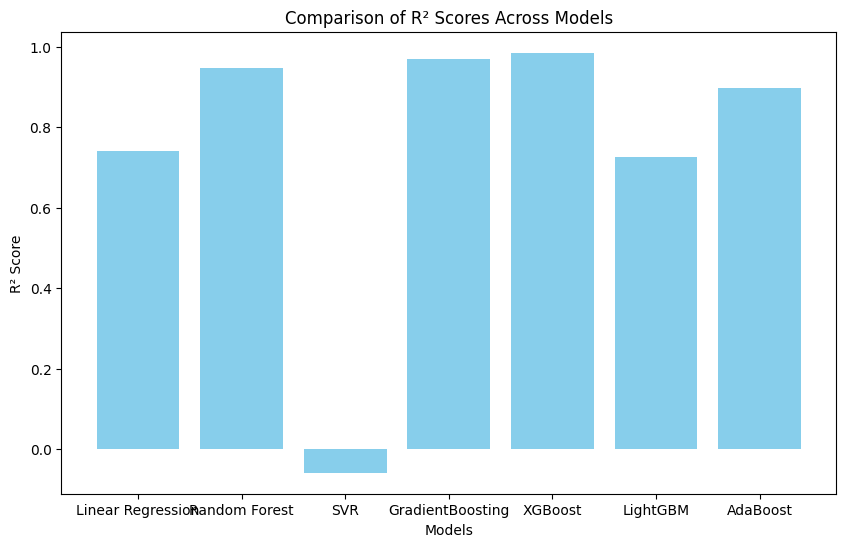

In [70]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.bar(models, df["R²"], color='skyblue')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Comparison of R² Scores Across Models')
plt.show()


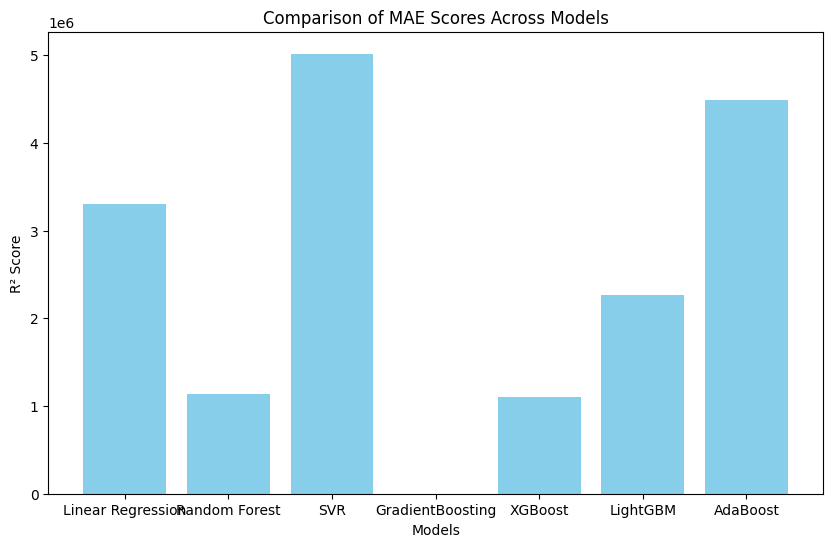

In [71]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.bar(models, df["MAE"], color='skyblue')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Comparison of MAE Scores Across Models')
plt.show()


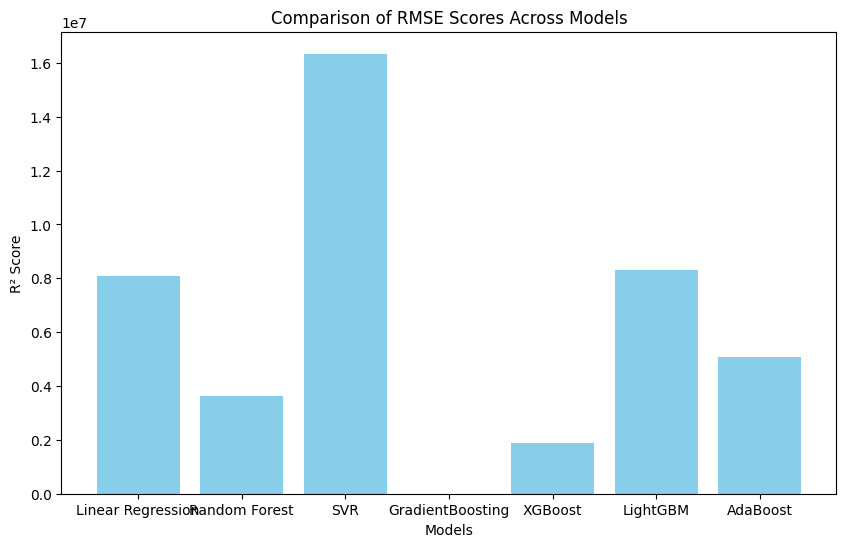

In [72]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.bar(models, df["RMSE"], color='skyblue')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Comparison of RMSE Scores Across Models')
plt.show()


In [73]:
df["RMSE"]

0    8.068772e+06
1    3.621847e+06
2    1.633788e+07
3    9.122729e+01
4    1.894700e+06
5    8.315684e+06
6    5.059706e+06
Name: RMSE, dtype: float64

## After further testing, XGBoost is performing even better than Gradient boosting

This isn't surprising since XGBoost is essentially an improved Gradient Boosting


### Optimisation et interprétation du modèle

A réaliser :
* Reprennez le meilleur algorithme que vous avez sécurisé via l'étape précédente, et réalisez une GridSearch de petite taille sur au moins 3 hyperparamètres.
* Si le meilleur modèle fait partie de la famille des modèles à arbres (RandomForest, GradientBoosting) alors utilisez la fonctionnalité feature importance pour identifier les features les plus impactantes sur la performance du modèle. Sinon, utilisez la méthode Permutation Importance de sklearn. 

In [74]:
X_train1

,PropertyParking,PropertyGFABuilding,ENERGYSTARScore,SteamUse,ElectricityUse,NaturalGasUse,Age,PropertyAreaTimesFloorWithParking,BuildingType_Nonresidential_COS,BuildingType_Nonresidential_WA,...,LargestPropertyUseType_Restaurant,LargestPropertyUseType_Retail_Store,LargestPropertyUseType_Self_Storage_Facility,LargestPropertyUseType_Senior_Care_Community,LargestPropertyUseType_Social_Meeting_Hall,LargestPropertyUseType_Strip_Mall,LargestPropertyUseType_Supermarket_Grocery_Store,LargestPropertyUseType_Urgent_Care_Clinic_Other_Outpatient,LargestPropertyUseType_Wholesale_Club_Supercenter,LargestPropertyUseType_Worship_Facility
159,0,-0.190385,1.420087,0,1,1,0.007854,-0.367528,0,0,...,0,0,0,0,0,0,0,0,0,0
69,0,1.952979,-2.104135,0,1,1,0.189754,1.275783,0,0,...,0,0,0,0,0,0,0,0,0,0
1231,0,-0.148212,1.420087,0,1,1,-0.143729,-0.157955,0,0,...,0,0,0,0,0,0,0,0,0,0
964,0,-0.480926,0.000000,0,1,1,0.311021,-0.405297,0,0,...,0,0,0,0,0,0,0,0,0,0
542,1,-0.454822,0.000000,0,1,1,1.068937,-0.400393,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0,-0.446415,0.000000,0,1,1,1.099254,-0.371545,0,0,...,0,0,0,0,0,0,0,0,0,0
1256,0,-0.363889,0.646477,0,1,0,-0.477212,-0.310095,0,0,...,0,0,0,0,0,0,0,0,0,0
860,1,-0.367440,0.000000,0,1,0,-1.083545,-0.229515,0,0,...,0,0,0,0,0,0,0,0,0,0
189,1,1.511000,0.603499,0,1,0,-0.628795,1.218395,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
# scikit-learn==1.5.2 pour la compatibilité gridSearchCV et XGBRegressor 
# https://stackoverflow.com/questions/79290968/super-object-has-no-attribute-sklearn-tags

# Define the model
xgb_model = XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=1337)

X_train_np = X_train1.values
y_train_np = y_train1.values.ravel() 

# Define hyperparameters for GridSearch
param_grid = {
    'learning_rate': [0.1, 0.15, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 70, 100, ],
    #'min_child_weight': [1, 3, 5],
    #'tree_method': ['exact', 'hist'],
}


# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
#cv = 3 means crossvalidation 3 fold

# Fit the model
grid_search.fit(X_train_np, y_train_np)

# Get the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Retrieve the best estimator
best_xgb_model = grid_search.best_estimator_


Fitting 3 folds for each of 27 candidates, totalling 81 fits


c:\Users\Dev\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
12 fits failed out of a total of 81.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Dev\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Dev\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\Dev\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboos

Best Parameters: {'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 100}
Best Score: -73796064096015.5


In [76]:
# Define the model
xgb_model = best_xgb_model

# Train the model
xgb_model.fit(X_train1, y_train1)

# Predict and evaluate on train set
y_train_pred_xgb = xgb_model.predict(X_train1)
r2_train_xgb = r2_score(y_train1, y_train_pred_xgb)
y_test_pred_xgb = xgb_model.predict(X_test1)
r2_test_xgb = r2_score(y_test1, y_test_pred_xgb)

# Calculate metrics for SVR
train_metrics_xgb = evaluate_model(y_train1, y_train_pred_xgb)
test_metrics_xgb = evaluate_model(y_test1, y_test_pred_xgb)

print("best_xgb_model (Train) R2, MAE, RMSE:", train_metrics_xgb)
print("best_xgb_model (Test) R2, MAE, RMSE:", test_metrics_xgb)



best_xgb_model (Train) R2, MAE, RMSE: (0.953170237090233, 1781352.1553385763, 3435318.1929764017)
best_xgb_model (Test) R2, MAE, RMSE: (0.5386012808616365, 2390835.0769734085, 5907514.5213758815)


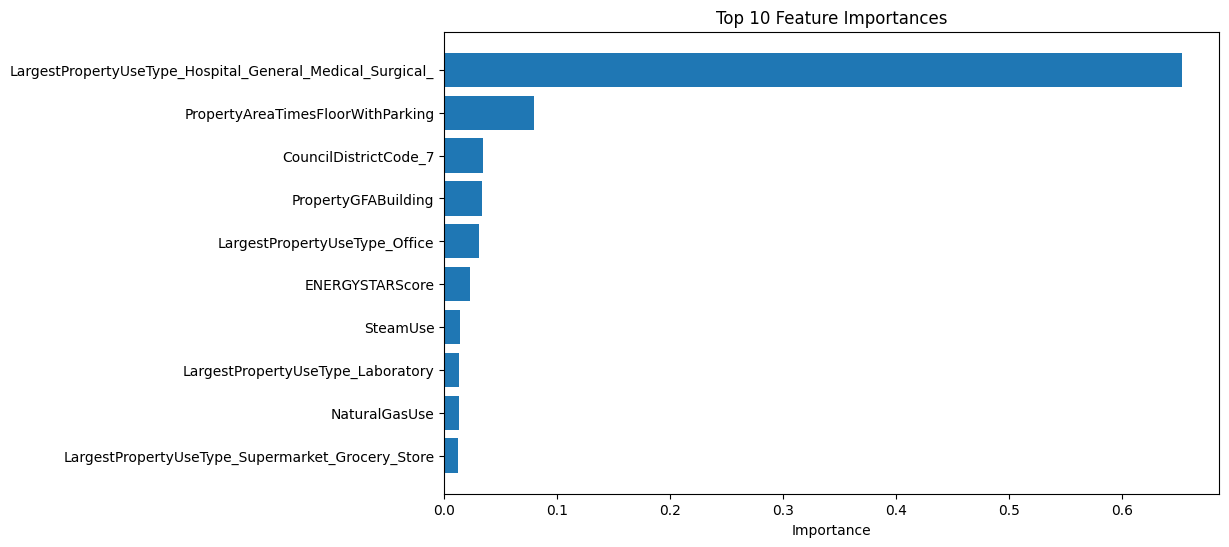

In [77]:
import matplotlib.pyplot as plt

# Get feature importances from the trained model
importances = best_xgb_model.feature_importances_

# Sort the features by importance in descending order
indices = importances.argsort()

# Select the top 10 most important features
top_n = 10
top_indices = indices[-top_n:]  # Get the indices of the top 10 features

# Plot the feature importances for the top 10 features
plt.figure(figsize=(10, 6))
plt.title(f"Top {top_n} Feature Importances")
plt.barh(range(top_n), importances[top_indices], align="center")
plt.yticks(range(top_n), [X_train1.columns[i] for i in top_indices])
plt.xlabel("Importance")
plt.show()


In [78]:
PropertyTypes = ['Adult Education', 'Automobile Dealership', 'Bank Branch', 'College/University',
                    'Convention Center', 'Courthouse', 'Data Center', 'Distribution Center',
                    'Financial Office', 'Fire Station', 'Fitness Center/Health Club/Gym',
                    'Food Service', 'Hospital (General Medical & Surgical)', 'Hotel', 'K-12 School',
                    'Laboratory', 'Library', 'Lifestyle Center', 'Manufacturing/Industrial Plant',
                    'Medical Office', 'Movie Theater', 'Multifamily Housing', 'Museum',
                    'Non-Refrigerated Warehouse', 'Office', 'Other', 'Other - Education',
                    'Other - Entertainment/Public Assembly', 'Other - Lodging/Residential',
                    'Other - Mall', 'Other - Public Services', 'Other - Recreation',
                    'Other - Restaurant/Bar', 'Other - Services', 'Other - Utility',
                    'Other/Specialty Hospital', 'Parking', 'Performing Arts',
                    'Personal Services (Health/Beauty, Dry Cleaning, etc)', 'Police Station',
                    'Pre-school/Daycare', 'Prison/Incarceration', 'Refrigerated Warehouse',
                    'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Residence Hall/Dormitory',
                    'Residential Care Facility', 'Restaurant', 'Retail Store', 'Self-Storage Facility',
                    'Senior Care Community', 'Social/Meeting Hall', 'Strip Mall',
                    'Supermarket/Grocery Store', 'Urgent Care/Clinic/Other Outpatient',
                    'Wholesale Club/Supercenter', 'Worship Facility']

BuildingType = ['NonResidential', 'Nonresidential COS', 'Nonresidential WA']
CouncilDistrictCode = [1, 2, 3, 4, 5, 6, 7]

In [79]:
columns_to_scale = ['PropertyGFATotal',
 'PropertyGFABuilding',
 'LargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'Age']
scaler = StandardScaler()


In [80]:
bentoml.xgboost.save_model(
    "xgb_model_with_scaler",
    xgb_model,  # The trained XGBoost model
    custom_objects={
        "scaler": scaler, 
        "columns_to_scale": columns_to_scale, 
        "categories": {
            "PropertyTypes" : PropertyTypes,
            "BuildingType" : BuildingType,
            "CouncilDistrictCode" : CouncilDistrictCode
    }},  # Attach preprocessing
    signatures={"predict": {"batchable": True}},  # Define the prediction signature
)

model_ref = bentoml.xgboost.get("xgb_model_with_scaler:latest")
print("Custom Objects:", model_ref.custom_objects)



Custom Objects: {'scaler': StandardScaler(), 'columns_to_scale': ['PropertyGFATotal', 'PropertyGFABuilding', 'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'Age'], 'categories': {'PropertyTypes': ['Adult Education', 'Automobile Dealership', 'Bank Branch', 'College/University', 'Convention Center', 'Courthouse', 'Data Center', 'Distribution Center', 'Financial Office', 'Fire Station', 'Fitness Center/Health Club/Gym', 'Food Service', 'Hospital (General Medical & Surgical)', 'Hotel', 'K-12 School', 'Laboratory', 'Library', 'Lifestyle Center', 'Manufacturing/Industrial Plant', 'Medical Office', 'Movie Theater', 'Multifamily Housing', 'Museum', 'Non-Refrigerated Warehouse', 'Office', 'Other', 'Other - Education', 'Other - Entertainment/Public Assembly', 'Other - Lodging/Residential', 'Other - Mall', 'Other - Public Services', 'Other - Recreation', 'Other - Restaurant/Bar', 'Other - Services', 'Other - Utility', 'Other/Specialty Hospital', 'Parking', 'Performing Arts', 'Personal Services (

In [81]:
model_ref = bentoml.xgboost.get("xgb_model_with_scaler:latest")

In [82]:
import os

os.environ["BENTOML_HOME"] = "./bentoml_store"
bentoml_home = os.path.abspath(os.environ["BENTOML_HOME"])
print("BENTOML_HOME is set to:", bentoml_home)

BENTOML_HOME is set to: c:\Users\Dev\Desktop\OpenClassroom\Project6\Anticipez les besoins en consommation de bâtiments\Predict-Energy-and-CO2-for-building\bentoml_store


In [83]:
model_ref = bentoml.xgboost.get("xgb_model_with_scaler:latest")
print("Custom Objects:", model_ref.custom_objects)

columns_to_scale = model_ref.custom_objects.get("columns_to_scale")
print("Columns to Scale:", columns_to_scale)

scaler = model_ref.custom_objects.get("scaler")
print("Scaler:", scaler)

categories = model_ref.custom_objects.get("categories")
print("Categories:", categories)

Custom Objects: {'scaler': StandardScaler(), 'columns_to_scale': ['PropertyGFATotal', 'PropertyGFABuilding', 'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'Age'], 'categories': {'PropertyTypes': ['Adult Education', 'Automobile Dealership', 'Bank Branch', 'College/University', 'Convention Center', 'Courthouse', 'Data Center', 'Distribution Center', 'Financial Office', 'Fire Station', 'Fitness Center/Health Club/Gym', 'Food Service', 'Hospital (General Medical & Surgical)', 'Hotel', 'K-12 School', 'Laboratory', 'Library', 'Lifestyle Center', 'Manufacturing/Industrial Plant', 'Medical Office', 'Movie Theater', 'Multifamily Housing', 'Museum', 'Non-Refrigerated Warehouse', 'Office', 'Other', 'Other - Education', 'Other - Entertainment/Public Assembly', 'Other - Lodging/Residential', 'Other - Mall', 'Other - Public Services', 'Other - Recreation', 'Other - Restaurant/Bar', 'Other - Services', 'Other - Utility', 'Other/Specialty Hospital', 'Parking', 'Performing Arts', 'Personal Services (

In [84]:
import shap
import xgboost as xgb

# Numba needs NumPy 2.0 or less. Got NumPy 2.1.

# Assuming you have already trained your best XGB model
# model = best_xgb_model  # Replace this with your trained model
model = xgb_model
# Fit the SHAP explainer
explainer = shap.Explainer(model)

# Calculate SHAP values for the training data (or any dataset you want to explain)
shap_values = explainer(features)  # features should be your feature data (DataFrame or numpy array)


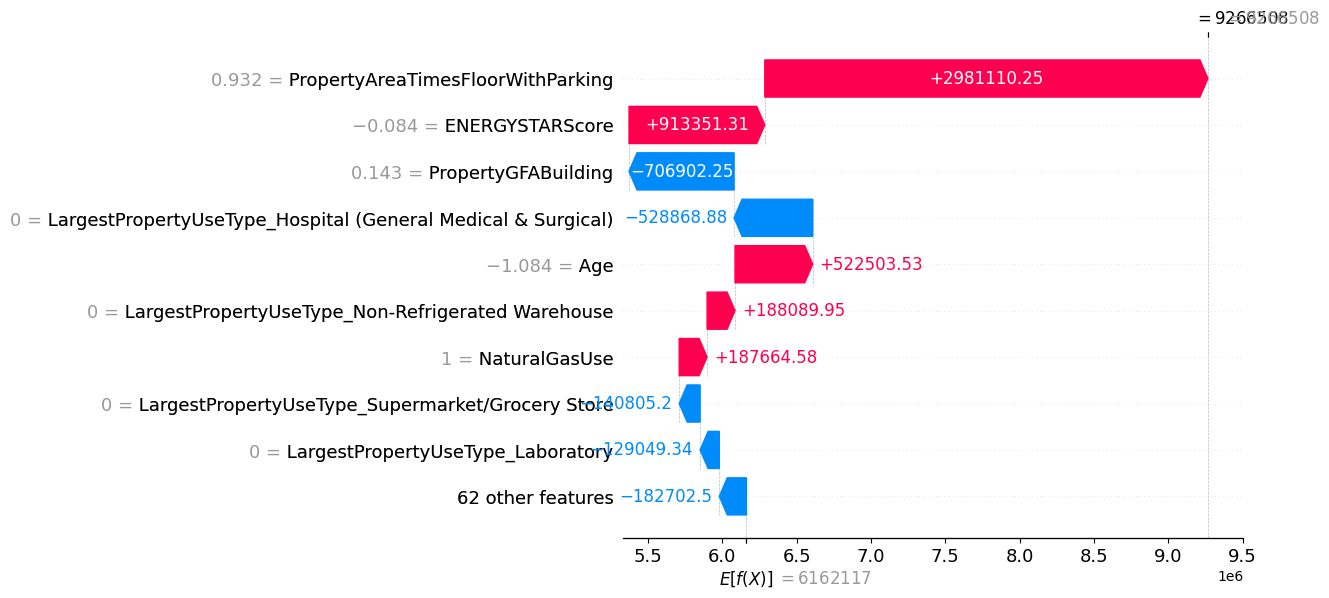

In [85]:
# visualize the first prediction's explanation
 
shap.plots.waterfall(shap_values[0])


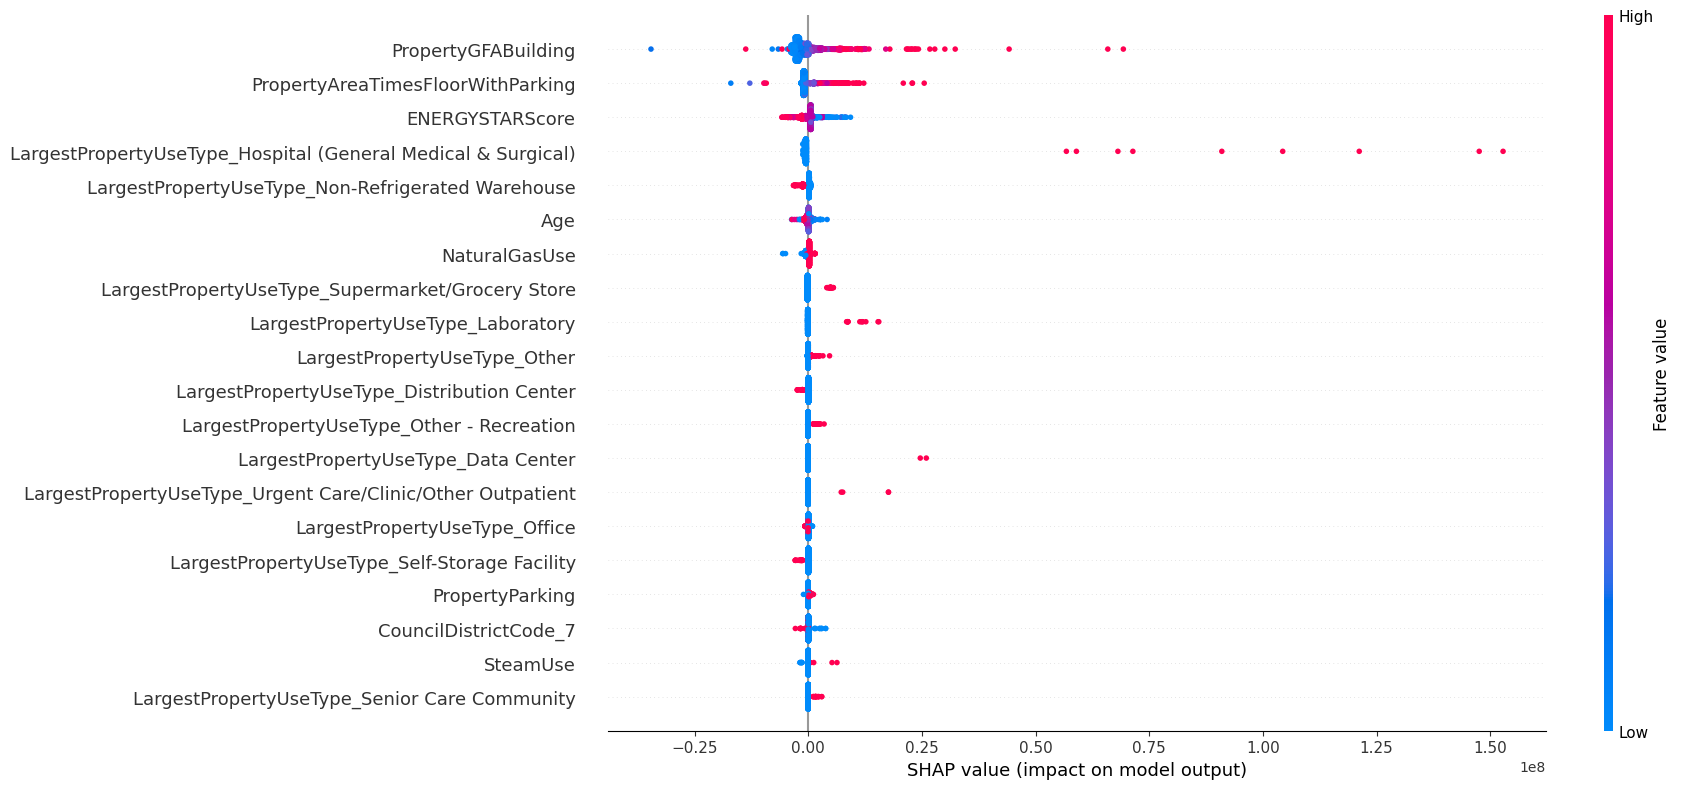

In [86]:
shap.summary_plot(shap_values, features, plot_size=(18, 8))  # Adjust the size as necessary



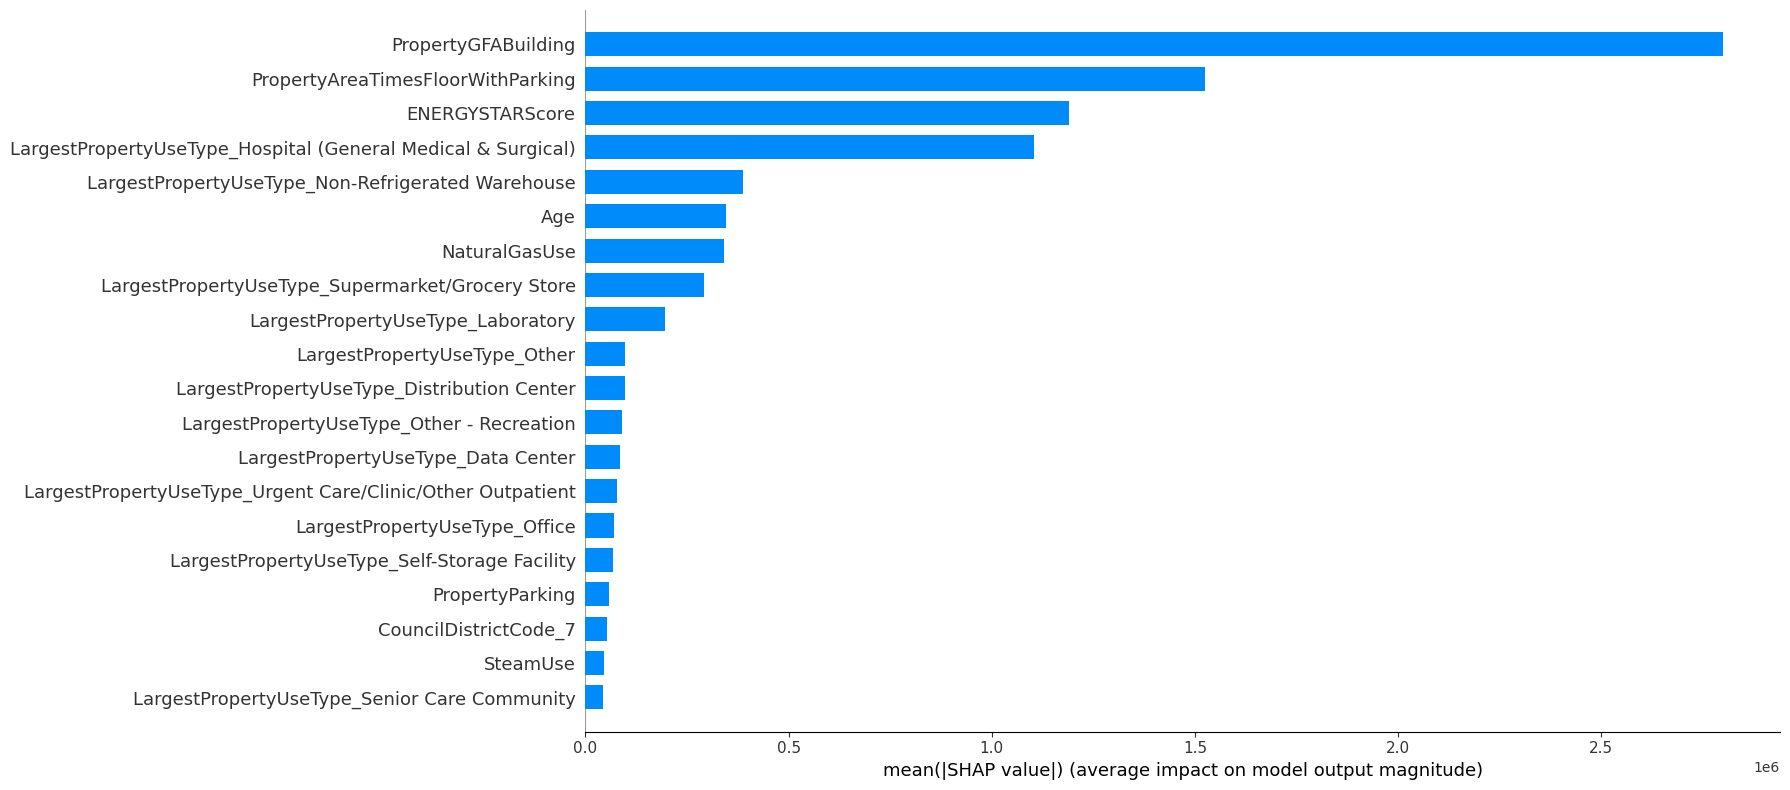

In [87]:
shap.summary_plot(shap_values, features, plot_type="bar", plot_size=(18, 8))


In [88]:
# Force Plot for the first prediction
shap.initjs()  # Initialize JavaScript for interactive plots
shap.force_plot(shap_values[0], features.iloc[0])